In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math


In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [4]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [5]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [6]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'Proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.show()
    #plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    #plt.close()

In [7]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = [[]]

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)
        momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type='fctmoy')

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(scardec_name)

    root_times = np.array(root_times)
    durations = np.array(durations)
    moments = np.log10(np.array(moments))
    relative_root_times = np.array(relative_root_times)

    rel_root_times = relative_root_times/durations

    all_relative_root_times.append(rel_root_times)


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [8]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#print(proportion)
durations = []
g_root_times = []
g_relative_root_times = []


for proportion in proportions_list:

    diff = []
    moments = []

    #for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)

    # Produce a Gaussian distribution
    def gaussian(x, mu, sigma):
        return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

    # Generate x values
    x = np.linspace(-4, 4, 100)

    # Parameters for the Gaussian
    mu = 0
    sigma = 1

    # Generate y values
    y = gaussian(x, mu, sigma)

    # Use the generated Gaussian values
    momentrate_opt, time_opt = y, x

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]
    durations.append(duration)

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
    moments.append(total_moment)
    g_root, r = scipy.optimize.bisect(f3,
                                    start_time+dx,
                                    end_time,
                                    rtol = 1e-6,
                                    full_output = True,
                                    args = (total_moment,
                                            time_opt,
                                            momentrate_opt,
                                            start,
                                            points_before_zero,
                                            proportion,))
    g_root_idx = np.floor(g_root/dx)
    g_root_time = g_root_idx*dx
    g_root_times.append(g_root_time)
    g_relative_root_times.append(g_root_time-start_time)

g_relative_root_times = np.array(g_relative_root_times)

In [9]:
def gaussian(x, mu = 0, sigma = 1):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [10]:
def triangle(x):
    x = np.array(x)
    y = np.zeros(len(x))
    m = 1/(abs(x[0]-x[int(len(x)/2)]))
    print(m)
    y[:int(len(x)/2)] = m*x[:int(len(x)/2)]
    y[int(len(x)/2):] = -m*x[int(len(x)/2):]
    y[:int(len(x)/2)] = y[:int(len(x)/2)] - min(y[:int(len(x)/2)])
    y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [11]:
def boxcar(x):
    y = np.zeros(len(x))
    y = y + 1
    return y

In [12]:
def trapezium(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.linspace(0, 1, start_index)
    y[start_index:length-end_index] = 1
    y[length-end_index:] = 1 - np.linspace(0, 1, end_index)
    return y


In [13]:
def sine_boxcar(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.sin(np.linspace(-math.pi/2, math.pi/2, start_index))
    y[start_index:length-end_index] = 1
    y[length-end_index:] = (np.sin(np.linspace(-math.pi/2, math.pi/2, start_index)))[::-1]
    return y

In [14]:
def comparison_calculation(funct):
    proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    #print(proportion)
    durations = []
    g_root_times = []
    g_relative_root_times = []


    for proportion in proportions_list:

        diff = []
        moments = []


        # Generate x values
        x = np.linspace(-4, 4, 100)

        # Generate y values
        y = funct(x)

        # Use the generated Gaussian values
        momentrate_opt, time_opt = y, x

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        g_root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        g_root_idx = np.floor(g_root/dx)
        g_root_time = g_root_idx*dx
        g_root_times.append(g_root_time)
        g_relative_root_times.append(g_root_time-start_time)

    g_relative_root_times = np.array(g_relative_root_times)
    return g_relative_root_times/durations

In [15]:
all_relative_root_times.append([])

0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33


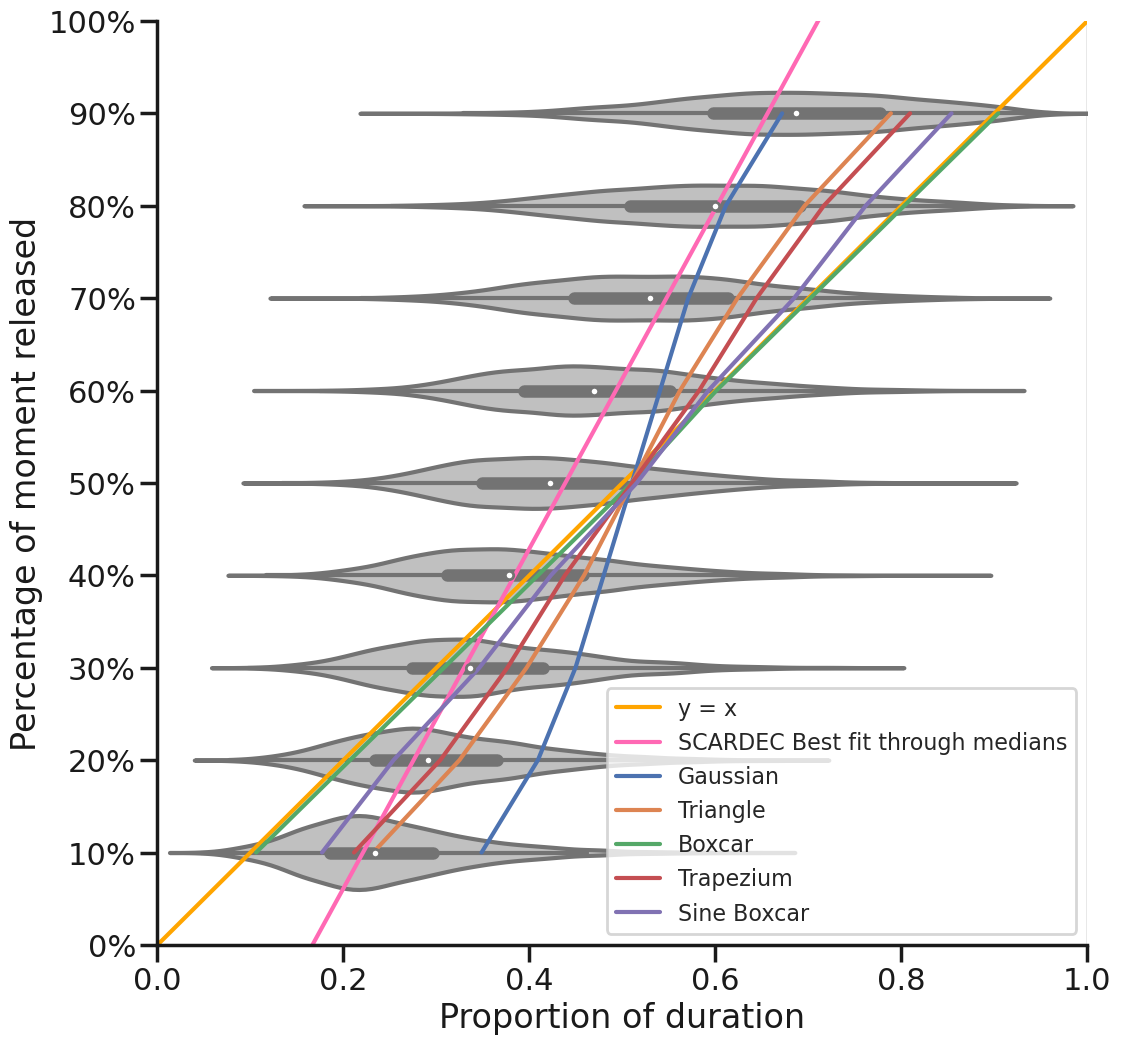

In [22]:
sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(10,10), "font.size":20})

sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':20})

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)
plt.rc('legend',fontsize=16)


ax = sns.violinplot(data = all_relative_root_times,
               orient = 'h',
               color = 'silver')
ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

ax.set_ylabel('Percentage of moment released')
ax.set_xlabel('Proportion of duration')

ax.invert_yaxis()

ax.plot(np.arange(0, 1.1, 0.1),
        np.arange(0, 11, 1),
        c = 'orange',
        label = 'y = x',)

# Calculate the line of best fit
m, b = np.polyfit(np.mean(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
#         c='red',
#         label = 'Mean LoBF',
#         linestyle = '--')

# Calculate the line of best fit
m, b = np.polyfit(np.median(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
ax.plot(np.arange(0, 1, 0.1),
        m * np.arange(0, 1, 0.1) + b,
        c='hotpink',
        label = 'SCARDEC Best fit through medians',
        linestyle = '-')


for funct, label in zip([gaussian, triangle, boxcar, trapezium, sine_boxcar], ['Gaussian', 'Triangle', 'Boxcar', 'Trapezium', 'Sine Boxcar']):
        ax.plot(comparison_calculation(funct), np.arange(1, 10, 1), label = label)

plt.ylim(-0, 10)
plt.xlim(0, 1)

ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
plt.legend()
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/comparisons_to_predictions/violinplot_fraction_of_duration_for_percent_moment_scardec_only.png', dpi = 300)

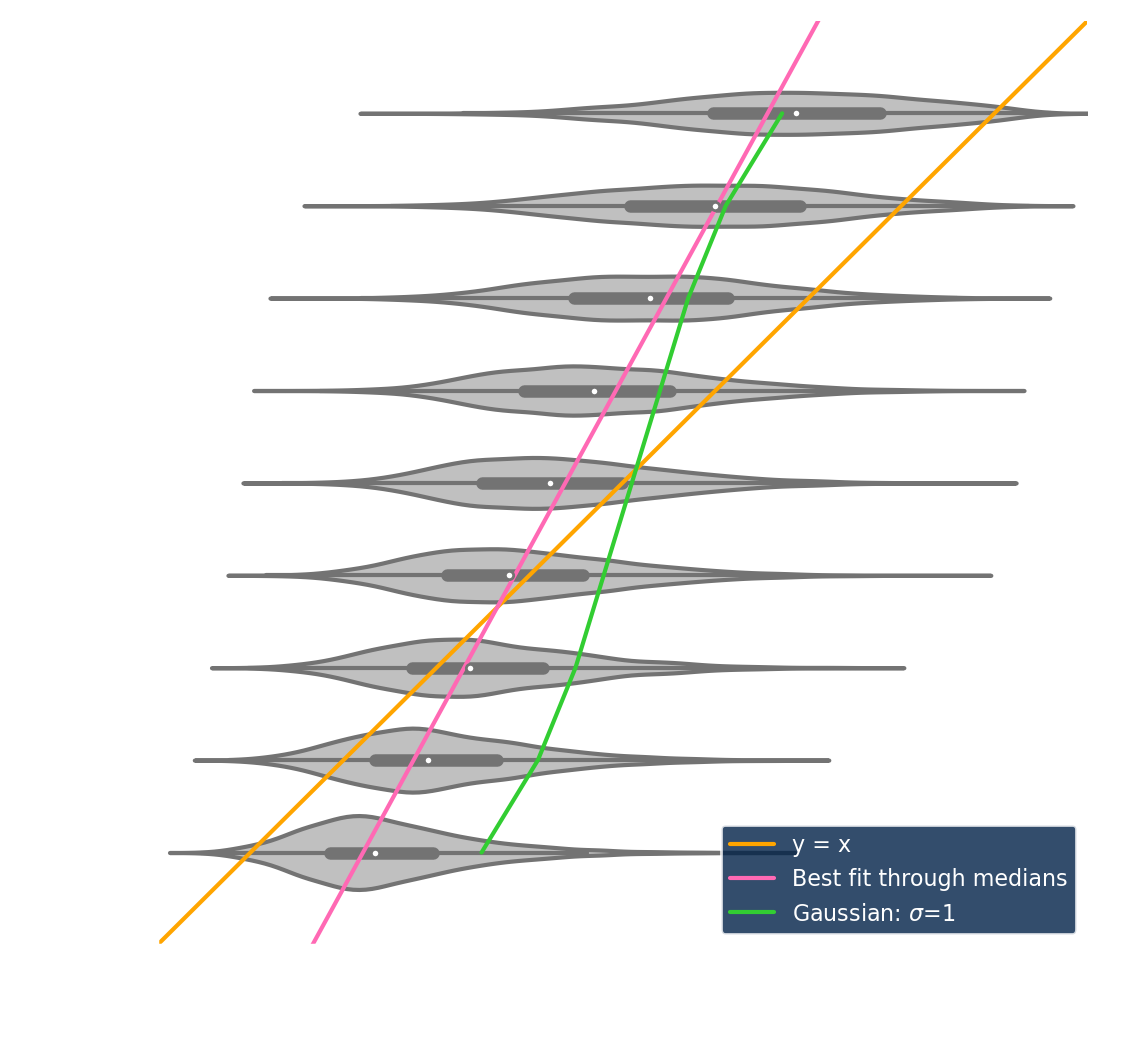

In [ ]:
#sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(20,20), "font.size":36})

sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':20})

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
plt.rc('legend',fontsize=20)

ax = sns.violinplot(data = all_relative_root_times,
               orient = 'h',
               color = 'silver')
ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.1))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.1)])

ax.set_ylabel('Percentage of moment released')
ax.set_xlabel('Proportion of duration')

ax.invert_yaxis()

ax.plot(np.arange(0, 1.1, 0.1),
        np.arange(0, 11, 1),
        c = 'orange',
        label = 'y = x',)

# Calculate the line of best fit
m, b = np.polyfit(np.mean(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
#         c='red',
#         label = 'Mean LoBF',
#         linestyle = '--')

# Calculate the line of best fit
m, b = np.polyfit(np.median(all_relative_root_times[1:-1], axis=1), np.arange(1, 10, 1), 1)
# Plot the line of best fit
ax.plot(np.arange(0, 1, 0.1),
        m * np.arange(0, 1, 0.1) + b,
        c='hotpink',
        label = 'Best fit through medians',
        linestyle = '-')

ax.plot(g_relative_root_times/durations, np.arange(1, 10, 1), label = r'Gaussian: $\sigma$=1', c = 'limegreen')

plt.ylim(-0, 10)
plt.xlim(0, 1)

#ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
plt.legend(ncol = 1, facecolor = '#002147', edgecolor = 'white', labelcolor = 'white', fontsize = 16)
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/violinplot_fraction_of_duration_for_percent_moment_with_gasussian_transparent.png', dpi = 300, transparent = True)